In [1]:
import pandas as pd
import numpy as np
import glob
import base64
import matplotlib.pyplot as plt
import os

from PIL import Image
from io import BytesIO
from IPython.display import HTML
from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline


In [2]:
lbl = pd.read_csv('labels.csv')
lbl.breed.value_counts()

scottish_deerhound                126
maltese_dog                       117
afghan_hound                      116
entlebucher                       115
bernese_mountain_dog              114
shih-tzu                          112
pomeranian                        111
great_pyrenees                    111
basenji                           110
samoyed                           109
tibetan_terrier                   107
airedale                          107
leonberg                          106
cairn                             106
beagle                            105
japanese_spaniel                  105
blenheim_spaniel                  102
miniature_pinscher                102
australian_terrier                102
irish_wolfhound                   101
saluki                             99
lakeland_terrier                   99
papillon                           96
siberian_husky                     95
norwegian_elkhound                 95
whippet                            95
pug         

In [3]:
pd.set_option('display.max_colwidth', -1)


def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

def get_full(path):
    i = Image.open(path)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

,breed,thumbnail
6406,afghan_hound,
7430,afghan_hound,
9796,afghan_hound,
3009,afghan_hound,
4952,afghan_hound,
7794,afghan_hound,
4820,afghan_hound,
3800,afghan_hound,
6467,afghan_hound,
1143,afghan_hound,

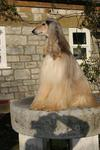
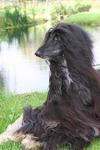
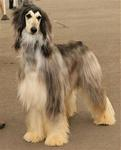
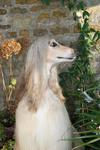
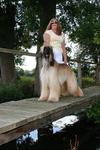
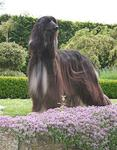
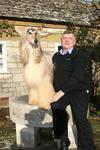
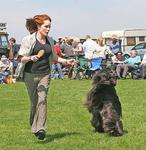
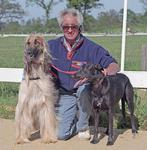
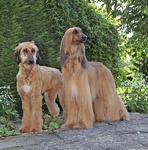

In [4]:
dogz = pd.read_csv('labels.csv')
dogs = dogz[dogz.breed=='afghan_hound'].copy().sample(10)
dogs['file'] = dogs.id.map(lambda id: f'./train/{id}.jpg')
dogs['thumbnail'] = dogs.file.map(lambda f: get_thumbnail(f))
dogs['image'] = dogs.file.map(lambda f: get_full(f))
# displaying PIL.Image objects embedded in dataframe
HTML(dogs[['breed', 'thumbnail']].to_html(formatters={'thumbnail': image_formatter}, escape=False))

,breed,thumbnail
1223,entlebucher,
6949,entlebucher,
5713,entlebucher,
6295,entlebucher,
4383,entlebucher,
6964,entlebucher,
2351,entlebucher,
1047,entlebucher,
4704,entlebucher,
7361,entlebucher,

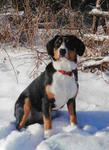
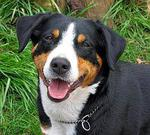
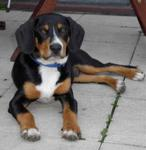
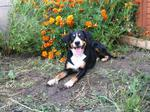
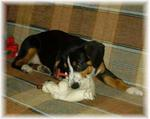
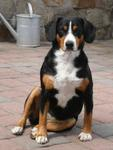
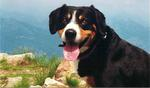
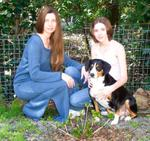
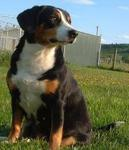
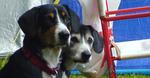

In [5]:
dogs = dogz[dogz.breed=='entlebucher'].copy().sample(10)
dogs['file'] = dogs.id.map(lambda id: f'./train/{id}.jpg')
dogs['thumbnail'] = dogs.file.map(lambda f: get_thumbnail(f))
dogs['image'] = dogs.file.map(lambda f: get_full(f))
# displaying PIL.Image objects embedded in dataframe
HTML(dogs[['breed', 'thumbnail']].to_html(formatters={'thumbnail': image_formatter}, escape=False))

In [6]:
desired_dogs = dogz[(dogz.breed=='entlebucher') | (dogz.breed=='afghan_hound')].copy()
dogs = pd.DataFrame(index=[0])
for row in desired_dogs.index:
    new_ind = len(dogs)
    id_ = desired_dogs['id'].loc[row]
    breed = desired_dogs['breed'].loc[row]
    try:
        img = Image.open(f'./bindogs/faces/resize/{id_}.bmp')
    except:
        img = None
    if img != None:
        new_row = pd.DataFrame(index=[new_ind])
        new_row['id'] = id_
        new_row['breed'] = breed
        new_row['image'] = [img]
        dogs = pd.concat([dogs, new_row], axis=0)
        
dogs = dogs.loc[1:].copy()

,breed,image
1,entlebucher,
2,entlebucher,
3,entlebucher,
4,afghan_hound,
5,afghan_hound,
6,afghan_hound,
7,entlebucher,
8,afghan_hound,
9,entlebucher,
10,entlebucher,

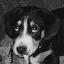
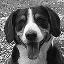
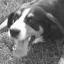
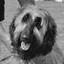
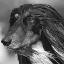
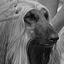
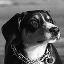
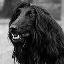
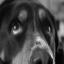
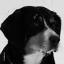
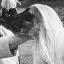
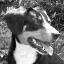
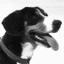
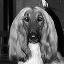
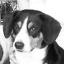
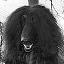
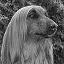
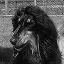
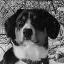
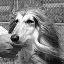
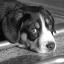
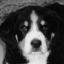
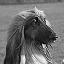
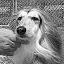
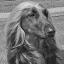
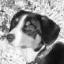
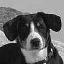
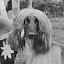
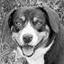
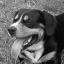
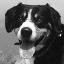
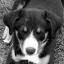
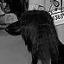
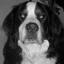
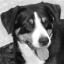
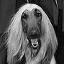
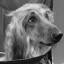
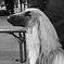
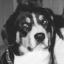
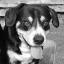
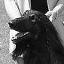
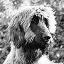
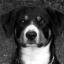
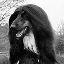
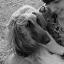
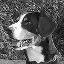
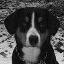
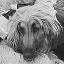
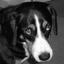
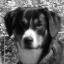
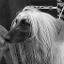
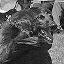
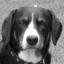
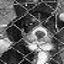
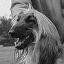
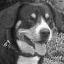
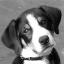
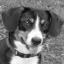
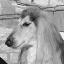
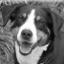
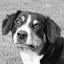
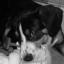
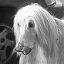
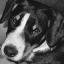
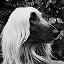
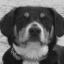
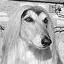
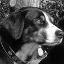
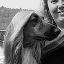
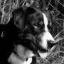
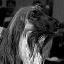
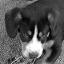
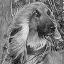
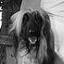
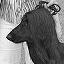
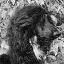
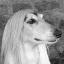
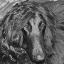
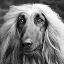
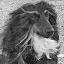
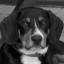
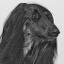
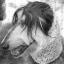
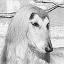
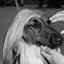
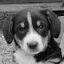
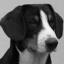
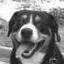
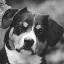
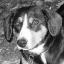
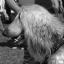
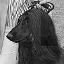
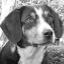
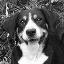
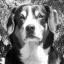

In [7]:
HTML(dogs[['breed', 'image']].to_html(formatters={'image': image_formatter}, escape=False))

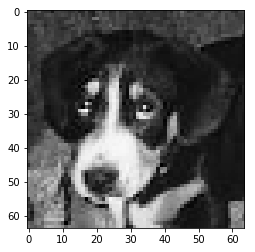

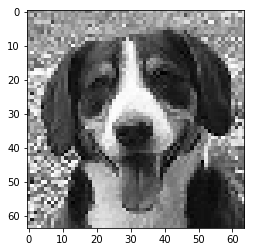

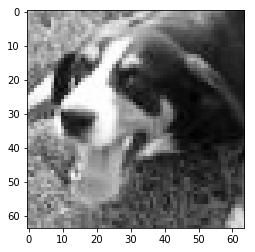

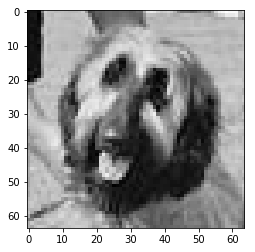

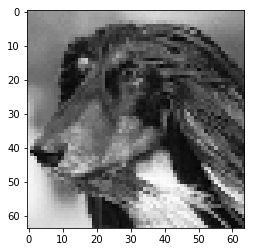

In [8]:
def to_bw(image_array):
    mn = image_array.mean()
    result = (image_array < mn)
    return np.where(result, 1, 0)

def invert_array(arr):
    mx = arr.max()
    result = mx - arr
    return result

#dogs['binary'] = dogs.image.apply(lambda x: to_bw(np.asarray(x)))
dogs['binary'] = dogs.image.apply(lambda x: invert_array(np.asarray(x)))
cnt = 0
for row in dogs.index:
    disp = dogs.loc[row]['binary']
    plt.imshow(disp, cmap='Greys');
    plt.show();
    cnt += 1
    if cnt > 4:
        break

In [9]:
def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 64x64 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    shift = lambda x, w: convolve(x.reshape((64, 64)), mode='constant',
                                  weights=w).ravel()
    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y


    shift = lambda x, w: convolve(x, mode='constant',
                                  weights=w).ravel()
    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

X_ = np.array([np.asarray(x).reshape(4096) for x in dogs.binary])
Y_ = np.asarray(dogs.breed)
X, Y = nudge_dataset(X_, Y_)
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

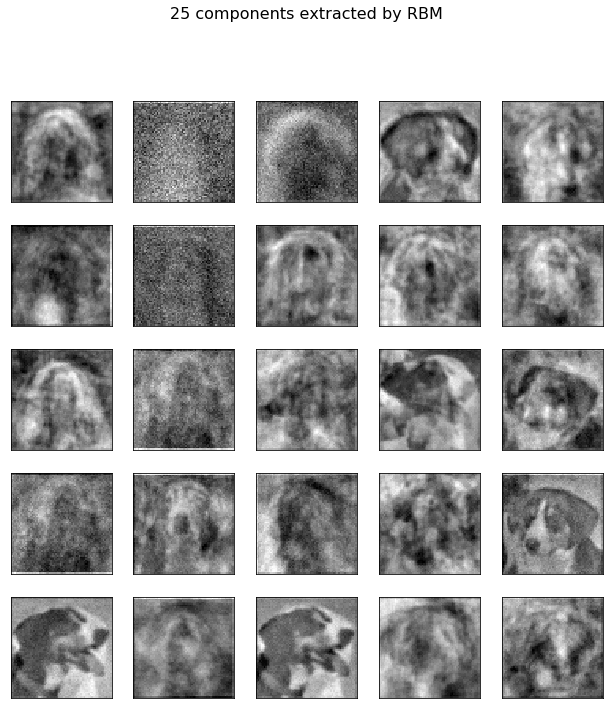

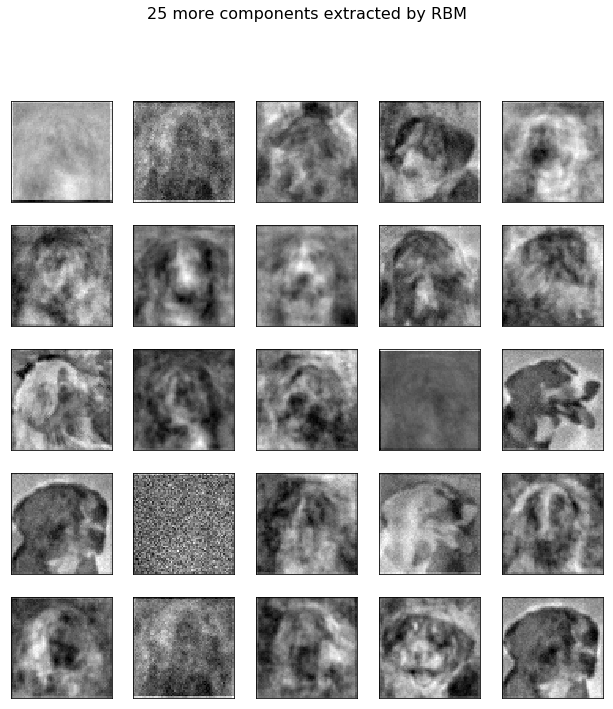

In [10]:
rbm1 = BernoulliRBM(
    random_state=0, 
    verbose=False,
    learning_rate = 0.01,
    n_iter = 200,
    n_components = 100
)

rbm1.fit(X, Y)

plt.figure(figsize=(10, 10))
for i, comp in enumerate(rbm1.components_[:25]):
    plt.subplot(5, 5, i + 1)
    plt.imshow(comp.reshape((64, 64)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('25 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()
plt.figure(figsize=(10, 10))
for i, comp in enumerate(rbm1.components_[25:50]):
    plt.subplot(5, 5, i + 1)
    plt.imshow(comp.reshape((64, 64)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('25 more components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X_, Y_,
                                                    test_size=0.2,
                                                    random_state=0)

X_train, Y_train = nudge_dataset(X_train, Y_train)
X_test, Y_test = nudge_dataset(X_test, Y_test)

svc = SVC()
rbm = BernoulliRBM(random_state=0, verbose=False)

classifier = Pipeline(steps=[('rbm', rbm), ('svc', svc)])

rbm.learning_rate = 0.01
rbm.n_iter = 100
rbm.n_components = 100
svc.alpha = .9

classifier.fit(X_train, Y_train)

svclassifier = SVC()
svclassifier.fit(X_train, Y_train)

#Evaluation

print()
print("SVC using RBM features:\n%s\n" % (
    metrics.classification_report(
        Y_test,
        classifier.predict(X_test))))

print("SVC using raw pixel features:\n%s\n" % (
    metrics.classification_report(
        Y_test,
        svclassifier.predict(X_test))))


SVC using RBM features:
              precision    recall  f1-score   support

afghan_hound       0.00      0.00      0.00        50
 entlebucher       0.47      1.00      0.64        45

 avg / total       0.22      0.47      0.30        95




/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC using raw pixel features:
              precision    recall  f1-score   support

afghan_hound       0.00      0.00      0.00        50
 entlebucher       0.47      1.00      0.64        45

 avg / total       0.22      0.47      0.30        95


